# anti skidding with vgg net

下载vgg

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


## ConvNet Codes

In [2]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [3]:
data_dir = 'pavement/'
contents = os.listdir(data_dir)#os.listdir(dirname)：列出dirname下的目录和文件
classes = [each for each in contents if os.path.isdir(data_dir + each)]#os.path.isdir(name):判断name是不是一个目录，name不是目录就返回false
#如果是目录名，那么对于contents中每一个each，class=each
#print(classes)

Below I'm running images through the VGG network in batches.

In [4]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 5
codes_list = []
labels = []
batch = []

codes = None

with tf.Session() as sess:
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope("content_vgg"):
        vgg.build(input_)

    for each in classes:
        #print(1)
        print("Starting {} images".format(each))
        #print(2)
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            #print(img.shape)
            batch.append(img.reshape((1, 224, 224, 3)))
            #print(1)
            labels.append(each)
            #print(labels)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                images = np.concatenate(batch)

                feed_dict = {input_: images}
                #print(feed_dict)
                codes_batch = sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

G:\git_cache\抗滑\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 1s
Starting 0 images
5 images processed
10 images processed
15 images processed
20 images processed
25 images processed
30 images processed
35 images processed
40 images processed
45 images processed
50 images processed
55 images processed
60 images processed
65 images processed
70 images processed
75 images processed
80 images processed
85 images processed
90 images processed
95 images processed
100 images processed
105 images processed
110 images processed
115 images processed
120 images processed
125 images processed
130 images processed
135 images processed
140 images processed
145 images processed
150 images processed
155 images processed
160 images processed
165 images processed
170 images processed
175 images processed
180 images processed
185 images processed
190 images processed
195 images processed
200 images processed
205 images processed
210 images processed
215 images process

1990 images processed
1995 images processed
2000 images processed
2005 images processed
2010 images processed
2015 images processed
2020 images processed
2025 images processed
2030 images processed
2035 images processed
2040 images processed
2045 images processed
2050 images processed
2055 images processed
2060 images processed
2065 images processed
2070 images processed
2075 images processed
2080 images processed
2085 images processed
2090 images processed
2095 images processed
2100 images processed
2105 images processed
2110 images processed
2115 images processed
2120 images processed
2125 images processed
2130 images processed
2135 images processed
2140 images processed
2145 images processed
2150 images processed
2155 images processed
2160 images processed
2165 images processed
2170 images processed
2175 images processed
2180 images processed
2185 images processed
2190 images processed
2195 images processed
2200 images processed
2205 images processed
2210 images processed
2215 image

In [5]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

## Building the Classifier

Now that we have codes for all the images, we can build a simple classifier on top of them. The codes behave just like normal input into a simple neural network. Below I'm going to have you do most of the work.

In [4]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))
print(labels)

['0' '0' '0' ..., '1' '1' '1']


### Data prep

As usual, now we need to one-hot encode our labels and create validation/test sets. First up, creating our labels!

> **Exercise:** From scikit-learn, use [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to create one-hot encoded vectors from the labels. 

In [5]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(labels)

labels_vecs = lb.transform(labels)
#print(labels_vecs)
#print(labels_vecs.shape)
a=np.array(labels_vecs)
b=np.array(1-labels_vecs)
labels_vecs=np.column_stack((b,a))


Now you'll want to create your training, validation, and test sets. An important thing to note here is that our labels and data aren't randomized yet. We'll want to shuffle our data so the validation and test sets contain data from all classes. Otherwise, you could end up with testing sets that are all one class. Typically, you'll also want to make sure that each smaller set has the same the distribution of classes as it is for the whole data set. The easiest way to accomplish both these goals is to use [`StratifiedShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) from scikit-learn.

You can create the splitter like so:
```
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
```
Then split the data with 
```
splitter = ss.split(x, y)
```

`ss.split` returns a generator of indices. You can pass the indices into the arrays to get the split sets. The fact that it's a generator means you either need to iterate over it, or use `next(splitter)` to get the indices. Be sure to read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) and the [user guide](http://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split).

> **Exercise:** Use StratifiedShuffleSplit to split the codes and labels into training, validation, and test sets.

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

train_idx, val_idx = next(ss.split(codes, labels))#训练集索引，验证集（含测试集）索引

half_val_len = int(len(val_idx)/2)#验证集平分
val_idx, test_idx = val_idx[:half_val_len], val_idx[half_val_len:]#验证集索引，测试集索引
#比例为0.8:0.1:0.1

train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]
test_x, test_y = codes[test_idx], labels_vecs[test_idx]

In [7]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)
#print(test_x,test_y)

Train shapes (x, y): (3720, 4096) (3720, 2)
Validation shapes (x, y): (465, 4096) (465, 2)
Test shapes (x, y): (465, 4096) (465, 2)


### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [8]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
print(inputs_)
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])
print(labels_)
fc = tf.contrib.layers.fully_connected(inputs_, 256)
print(fc)
logits = tf.contrib.layers.fully_connected(fc, labels_vecs.shape[1], activation_fn=None)#输出结果
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
print(cross_entropy)
cost = tf.reduce_mean(cross_entropy)
print(cost)
optimizer = tf.train.AdamOptimizer().minimize(cost)



predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Tensor("Placeholder:0", shape=(?, 4096), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 2), dtype=int64)
Tensor("fully_connected/Relu:0", shape=(?, 256), dtype=float32)
Tensor("Reshape_2:0", shape=(?,), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)


### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

In [9]:
def get_batches(x, y, n_batches=20):#n_batches和之前处理图片的batch_size无关，这个是把codes做成batch  n_batches就是多少个batch，一个epoch迭代n_batches次
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help.

In [10]:
epochs = 60#所有样本训练这么多次
iteration = 0#迭代数就是batch有多少个，即总样本数/batchsize
saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for x, y in get_batches(train_x, train_y):
            feed = {inputs_: x,
                    labels_: y}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Iteration: {}".format(iteration),
                  "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 10 == 0:#求余数,每迭代这么多次验证一下（原数据是一个epoch迭代10次，每5次一验证）
                feed = {inputs_: val_x,
                        labels_: val_y}
                val_acc = sess.run(accuracy, feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints/pavement.ckpt")

Epoch: 1/60 Iteration: 0 Training loss: 0.93704
Epoch: 1/60 Iteration: 1 Training loss: 1.53263
Epoch: 1/60 Iteration: 2 Training loss: 7.41368
Epoch: 1/60 Iteration: 3 Training loss: 1.31020
Epoch: 1/60 Iteration: 4 Training loss: 0.87787
Epoch: 1/60 Iteration: 5 Training loss: 0.82781
Epoch: 1/60 Iteration: 6 Training loss: 1.15944
Epoch: 1/60 Iteration: 7 Training loss: 1.52070
Epoch: 1/60 Iteration: 8 Training loss: 0.97820
Epoch: 1/60 Iteration: 9 Training loss: 1.78946
Epoch: 0/60 Iteration: 10 Validation Acc: 0.6989
Epoch: 1/60 Iteration: 10 Training loss: 0.73785
Epoch: 1/60 Iteration: 11 Training loss: 1.10712
Epoch: 1/60 Iteration: 12 Training loss: 0.73932
Epoch: 1/60 Iteration: 13 Training loss: 0.70038
Epoch: 1/60 Iteration: 14 Training loss: 1.23316
Epoch: 1/60 Iteration: 15 Training loss: 0.77569
Epoch: 1/60 Iteration: 16 Training loss: 0.94081
Epoch: 1/60 Iteration: 17 Training loss: 1.09809
Epoch: 1/60 Iteration: 18 Training loss: 0.45802
Epoch: 1/60 Iteration: 19 Trai

Epoch: 8/60 Iteration: 151 Training loss: 0.19602
Epoch: 8/60 Iteration: 152 Training loss: 0.29125
Epoch: 8/60 Iteration: 153 Training loss: 0.25634
Epoch: 8/60 Iteration: 154 Training loss: 0.27702
Epoch: 8/60 Iteration: 155 Training loss: 0.25019
Epoch: 8/60 Iteration: 156 Training loss: 0.27589
Epoch: 8/60 Iteration: 157 Training loss: 0.28793
Epoch: 8/60 Iteration: 158 Training loss: 0.22724
Epoch: 8/60 Iteration: 159 Training loss: 0.20493
Epoch: 7/60 Iteration: 160 Validation Acc: 0.8022
Epoch: 9/60 Iteration: 160 Training loss: 0.21791
Epoch: 9/60 Iteration: 161 Training loss: 0.20650
Epoch: 9/60 Iteration: 162 Training loss: 0.24695
Epoch: 9/60 Iteration: 163 Training loss: 0.21990
Epoch: 9/60 Iteration: 164 Training loss: 0.27088
Epoch: 9/60 Iteration: 165 Training loss: 0.23914
Epoch: 9/60 Iteration: 166 Training loss: 0.24013
Epoch: 9/60 Iteration: 167 Training loss: 0.28820
Epoch: 9/60 Iteration: 168 Training loss: 0.25295
Epoch: 9/60 Iteration: 169 Training loss: 0.23878


Epoch: 15/60 Iteration: 298 Training loss: 0.12559
Epoch: 15/60 Iteration: 299 Training loss: 0.16795
Epoch: 14/60 Iteration: 300 Validation Acc: 0.8387
Epoch: 16/60 Iteration: 300 Training loss: 0.12157
Epoch: 16/60 Iteration: 301 Training loss: 0.13754
Epoch: 16/60 Iteration: 302 Training loss: 0.17003
Epoch: 16/60 Iteration: 303 Training loss: 0.12980
Epoch: 16/60 Iteration: 304 Training loss: 0.15636
Epoch: 16/60 Iteration: 305 Training loss: 0.16036
Epoch: 16/60 Iteration: 306 Training loss: 0.14380
Epoch: 16/60 Iteration: 307 Training loss: 0.17220
Epoch: 16/60 Iteration: 308 Training loss: 0.13406
Epoch: 16/60 Iteration: 309 Training loss: 0.12814
Epoch: 15/60 Iteration: 310 Validation Acc: 0.8301
Epoch: 16/60 Iteration: 310 Training loss: 0.16033
Epoch: 16/60 Iteration: 311 Training loss: 0.10986
Epoch: 16/60 Iteration: 312 Training loss: 0.13694
Epoch: 16/60 Iteration: 313 Training loss: 0.14821
Epoch: 16/60 Iteration: 314 Training loss: 0.15454
Epoch: 16/60 Iteration: 315 Tra

Epoch: 23/60 Iteration: 443 Training loss: 0.17509
Epoch: 23/60 Iteration: 444 Training loss: 0.09939
Epoch: 23/60 Iteration: 445 Training loss: 0.10950
Epoch: 23/60 Iteration: 446 Training loss: 0.14624
Epoch: 23/60 Iteration: 447 Training loss: 0.12312
Epoch: 23/60 Iteration: 448 Training loss: 0.09833
Epoch: 23/60 Iteration: 449 Training loss: 0.09450
Epoch: 22/60 Iteration: 450 Validation Acc: 0.8452
Epoch: 23/60 Iteration: 450 Training loss: 0.09193
Epoch: 23/60 Iteration: 451 Training loss: 0.12028
Epoch: 23/60 Iteration: 452 Training loss: 0.09590
Epoch: 23/60 Iteration: 453 Training loss: 0.13798
Epoch: 23/60 Iteration: 454 Training loss: 0.11302
Epoch: 23/60 Iteration: 455 Training loss: 0.13014
Epoch: 23/60 Iteration: 456 Training loss: 0.13891
Epoch: 23/60 Iteration: 457 Training loss: 0.09520
Epoch: 23/60 Iteration: 458 Training loss: 0.17472
Epoch: 23/60 Iteration: 459 Training loss: 0.07569
Epoch: 22/60 Iteration: 460 Validation Acc: 0.7978
Epoch: 24/60 Iteration: 460 Tra

Epoch: 30/60 Iteration: 589 Training loss: 0.48301
Epoch: 29/60 Iteration: 590 Validation Acc: 0.8151
Epoch: 30/60 Iteration: 590 Training loss: 0.16419
Epoch: 30/60 Iteration: 591 Training loss: 0.14468
Epoch: 30/60 Iteration: 592 Training loss: 0.37866
Epoch: 30/60 Iteration: 593 Training loss: 0.43200
Epoch: 30/60 Iteration: 594 Training loss: 0.12539
Epoch: 30/60 Iteration: 595 Training loss: 0.31373
Epoch: 30/60 Iteration: 596 Training loss: 0.48285
Epoch: 30/60 Iteration: 597 Training loss: 0.14154
Epoch: 30/60 Iteration: 598 Training loss: 0.13253
Epoch: 30/60 Iteration: 599 Training loss: 0.42688
Epoch: 29/60 Iteration: 600 Validation Acc: 0.7806
Epoch: 31/60 Iteration: 600 Training loss: 0.38705
Epoch: 31/60 Iteration: 601 Training loss: 0.09201
Epoch: 31/60 Iteration: 602 Training loss: 0.30175
Epoch: 31/60 Iteration: 603 Training loss: 0.39044
Epoch: 31/60 Iteration: 604 Training loss: 0.17481
Epoch: 31/60 Iteration: 605 Training loss: 0.13155
Epoch: 31/60 Iteration: 606 Tra

Epoch: 37/60 Iteration: 734 Training loss: 0.04146
Epoch: 37/60 Iteration: 735 Training loss: 0.03961
Epoch: 37/60 Iteration: 736 Training loss: 0.04873
Epoch: 37/60 Iteration: 737 Training loss: 0.04665
Epoch: 37/60 Iteration: 738 Training loss: 0.04218
Epoch: 37/60 Iteration: 739 Training loss: 0.03916
Epoch: 36/60 Iteration: 740 Validation Acc: 0.8516
Epoch: 38/60 Iteration: 740 Training loss: 0.04220
Epoch: 38/60 Iteration: 741 Training loss: 0.04263
Epoch: 38/60 Iteration: 742 Training loss: 0.05292
Epoch: 38/60 Iteration: 743 Training loss: 0.05022
Epoch: 38/60 Iteration: 744 Training loss: 0.04926
Epoch: 38/60 Iteration: 745 Training loss: 0.03493
Epoch: 38/60 Iteration: 746 Training loss: 0.03537
Epoch: 38/60 Iteration: 747 Training loss: 0.06610
Epoch: 38/60 Iteration: 748 Training loss: 0.04525
Epoch: 38/60 Iteration: 749 Training loss: 0.05294
Epoch: 37/60 Iteration: 750 Validation Acc: 0.8581
Epoch: 38/60 Iteration: 750 Training loss: 0.05569
Epoch: 38/60 Iteration: 751 Tra

Epoch: 43/60 Iteration: 880 Validation Acc: 0.8215
Epoch: 45/60 Iteration: 880 Training loss: 0.07185
Epoch: 45/60 Iteration: 881 Training loss: 0.13420
Epoch: 45/60 Iteration: 882 Training loss: 0.04324
Epoch: 45/60 Iteration: 883 Training loss: 0.06714
Epoch: 45/60 Iteration: 884 Training loss: 0.12396
Epoch: 45/60 Iteration: 885 Training loss: 0.04634
Epoch: 45/60 Iteration: 886 Training loss: 0.03481
Epoch: 45/60 Iteration: 887 Training loss: 0.09634
Epoch: 45/60 Iteration: 888 Training loss: 0.05527
Epoch: 45/60 Iteration: 889 Training loss: 0.03496
Epoch: 44/60 Iteration: 890 Validation Acc: 0.8344
Epoch: 45/60 Iteration: 890 Training loss: 0.03867
Epoch: 45/60 Iteration: 891 Training loss: 0.07154
Epoch: 45/60 Iteration: 892 Training loss: 0.07802
Epoch: 45/60 Iteration: 893 Training loss: 0.03167
Epoch: 45/60 Iteration: 894 Training loss: 0.07939
Epoch: 45/60 Iteration: 895 Training loss: 0.08312
Epoch: 45/60 Iteration: 896 Training loss: 0.04616
Epoch: 45/60 Iteration: 897 Tra

Epoch: 52/60 Iteration: 1025 Training loss: 0.02076
Epoch: 52/60 Iteration: 1026 Training loss: 0.03499
Epoch: 52/60 Iteration: 1027 Training loss: 0.02566
Epoch: 52/60 Iteration: 1028 Training loss: 0.02040
Epoch: 52/60 Iteration: 1029 Training loss: 0.01982
Epoch: 51/60 Iteration: 1030 Validation Acc: 0.8559
Epoch: 52/60 Iteration: 1030 Training loss: 0.01613
Epoch: 52/60 Iteration: 1031 Training loss: 0.01390
Epoch: 52/60 Iteration: 1032 Training loss: 0.01694
Epoch: 52/60 Iteration: 1033 Training loss: 0.01710
Epoch: 52/60 Iteration: 1034 Training loss: 0.01989
Epoch: 52/60 Iteration: 1035 Training loss: 0.01870
Epoch: 52/60 Iteration: 1036 Training loss: 0.02855
Epoch: 52/60 Iteration: 1037 Training loss: 0.02513
Epoch: 52/60 Iteration: 1038 Training loss: 0.01969
Epoch: 52/60 Iteration: 1039 Training loss: 0.02014
Epoch: 51/60 Iteration: 1040 Validation Acc: 0.8602
Epoch: 53/60 Iteration: 1040 Training loss: 0.01494
Epoch: 53/60 Iteration: 1041 Training loss: 0.00929
Epoch: 53/60

Epoch: 59/60 Iteration: 1168 Training loss: 0.01218
Epoch: 59/60 Iteration: 1169 Training loss: 0.03103
Epoch: 58/60 Iteration: 1170 Validation Acc: 0.8258
Epoch: 59/60 Iteration: 1170 Training loss: 0.03194
Epoch: 59/60 Iteration: 1171 Training loss: 0.01637
Epoch: 59/60 Iteration: 1172 Training loss: 0.00877
Epoch: 59/60 Iteration: 1173 Training loss: 0.01463
Epoch: 59/60 Iteration: 1174 Training loss: 0.03201
Epoch: 59/60 Iteration: 1175 Training loss: 0.01844
Epoch: 59/60 Iteration: 1176 Training loss: 0.01801
Epoch: 59/60 Iteration: 1177 Training loss: 0.00919
Epoch: 59/60 Iteration: 1178 Training loss: 0.00982
Epoch: 59/60 Iteration: 1179 Training loss: 0.02456
Epoch: 58/60 Iteration: 1180 Validation Acc: 0.8430
Epoch: 60/60 Iteration: 1180 Training loss: 0.01997
Epoch: 60/60 Iteration: 1181 Training loss: 0.01514
Epoch: 60/60 Iteration: 1182 Training loss: 0.01096
Epoch: 60/60 Iteration: 1183 Training loss: 0.01272
Epoch: 60/60 Iteration: 1184 Training loss: 0.02677
Epoch: 60/60

epoch:30,iteration:20,validation:per 10 iterations, Validation Acc: 0.8151, Test accuracy: 0.8237

epoch:60,iteration:20,validation:per 10 iterations, Validation Acc: 0.8115, Test accuracy: 0.8409

epoch:100,iteration:30,validation:per 10 iterations, Validation Acc: , Test accuracy: 0.8194

epoch:100,iteration:20,validation:per 10 iterations, Validation Acc: 0.8323, Test accuracy: 0.7957

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [11]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints\pavement.ckpt
Test accuracy: 0.8086


In [126]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

用训练好的网络测试图片

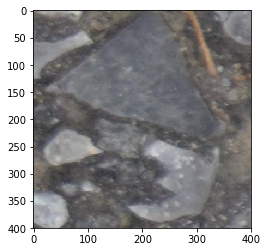

In [127]:
test_img_path = 'pavement/0/89.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [128]:
# Run this cell if you don't have a vgg graph built 有codes之后跳过的那一步，就把vgg graph built跳过去了。所以这一步还要再跑一次
with tf.Session() as sess:
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    vgg = vgg16.Vgg16()
    vgg.build(input_)

G:\git_cache\抗滑\tensorflow_vgg\vgg16.npy
npy file loaded
build model started
build model finished: 1s


In [129]:
with tf.Session() as sess:
    img = utils.load_image(test_img_path)
    img = img.reshape((1, 224, 224, 3))

    feed_dict = {input_: img}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)#把img变成code
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))#读取训练好的网络
    
    feed = {inputs_: code}#用code训练
    prediction = sess.run(predicted, feed_dict=feed).squeeze#预测()

INFO:tensorflow:Restoring parameters from checkpoints\pavement.ckpt


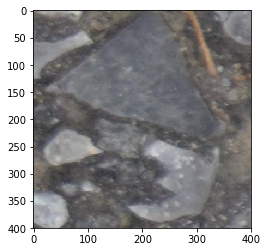

In [130]:
plt.imshow(test_img)

In [132]:
print(prediction)

[ 0.95318979  0.04681023]


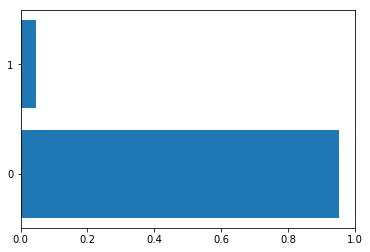

In [133]:
plt.barh(np.arange(2), prediction)
_ = plt.yticks(np.arange(2), lb.classes_)